# Homework 3 solutions
### ASTROINFORMATICS
## Problem 1

We learned this week that the posterior pdf for $b$, the tail probability when
flipping a coin, with a flat prior in the range 0-1, is
$$ p(b \,|\, k, N ) = C \, b^k \, (1-b)^{N-k}, $$
where the normalization constant $C$ can be determined from the condition $\int_0^1 p(b\,|\,k,N)\, db = 1$.

Get a coin, flip it 8 times and record the results.

a) plot $p(b \,|\, k, N )$ after each flip. Every time show the previous (prior) $p(b)$
and the posterior $p(b)$. 

b) After all 8 flips, what is the probability that your coin strongly prefers
heads over tails: what is the probability $p(b<0.25\,|\, k, N )$)? 


## Problem 2

Fit polynomials of up to the 5th order to the provided dataset.
Use BIC to find the best model for this dataset.

## Problem 3 

Apply Bayesian Blocks Algorithm to period distribution (logP) of LINEAR variable stars. 
Plot histograms on both linear and log scale. Compare the result to classical (Knuth's) 
uniform bin width histogram. 

### Some useful definitions and functions

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from astroML.datasets import fetch_LINEAR_geneva
from astroML.plotting import setup_text_plots
from astroML.plotting import hist
setup_text_plots(fontsize=12, usetex=True)

## Problem 1: the coin flip

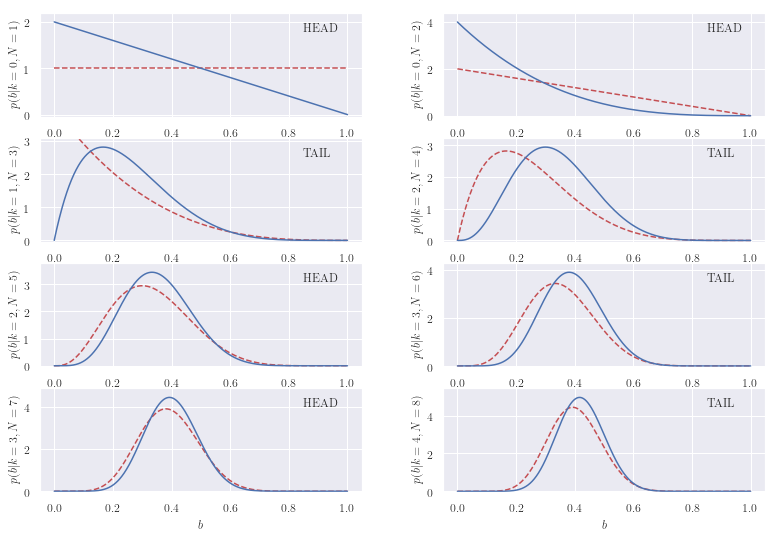

p(b<0.25):  0.011894078069101604


In [9]:
from scipy.stats import norm
np.random.seed(42)
# results for my coin (0:head, 1: tail)
flipData = [0, 0, 1, 1, 0, 1, 0, 1]
# plotting setup 
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.25, bottom=0.18)
 
# b grid for computing p(b) 
b = np.linspace(0,1,1000)
db = b[1]-b[0]
# prior 
p_b = 1.0 + 0*b   # flat prior
# p_b = norm(0.5, 0.1).pdf(b)   Gaussian prior

# loop over data
for i in range(1,9):
    ax = fig.add_subplot('52' + str(i))
    # show p_b before this data point is added
    ax.plot(b, p_b, '--r')
    # now get new p_b
    N = i 
    k = flipData[0:i].count(1)
    p_b = p_b * (b ** k * (1 - b) ** (N - k))
    p_b /= p_b.sum()
    p_b /= db
    # p_b after this data point is added
    label=' z'
    ax.plot(b, p_b, '-b', label=label)
    ax.set_xlabel('$b$')
    s = '$p(b|k=%i' % k
    s = s + ', N=%i)$' % N
    if (flipData[i-1] == 0): 
        ax.text(0.85, np.max(p_b)*0.9,'HEAD')
    else:
        ax.text(0.85, np.max(p_b)*0.9,'TAIL')
    ax.set_ylabel(s)
    ax.set_ylim(-0.05, np.max(p_b)*1.1)
    
plt.show()

cuml_p_b = p_b.cumsum()
cuml_p_b /= cuml_p_b[-1]
print('p(b<0.25): ', np.interp(0.25, b, cuml_p_b)) 


## Problem 2: use BIC to find the best polynomial model for a given dataset

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # set default plot styles
from scipy import stats
from scipy import optimize

# this function computes polynomial models given some data x
# and parameters theta
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, x, y, sigma_y, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(degree, x, y, sigma_y, model=polynomial_fit):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, x, y, sigma_y, model)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

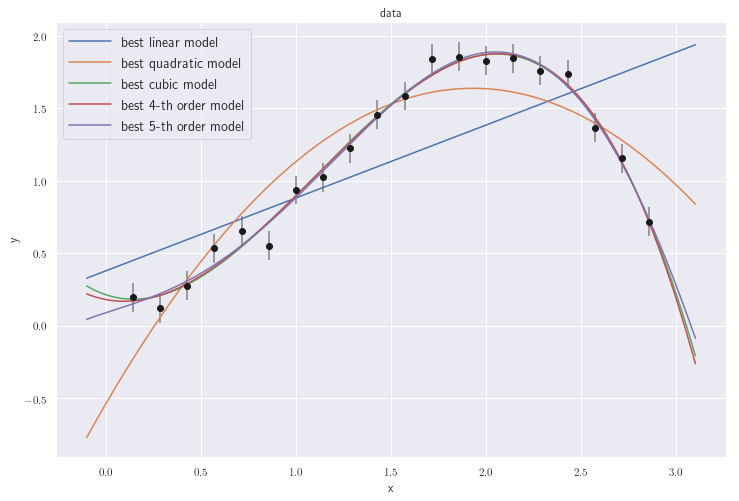

In [11]:
# generate (noisy) data
np.random.seed(0)
Ndata = 22
x = np.linspace(0, 3, Ndata)[1:-1]
sigma_y = 0.1 + 0*x
y = np.random.normal(np.sin(x) * x, sigma_y) 
# data = np.array([x, y, sigma_y])

# get best-fit parameters for linear, quadratic and cubic models
theta1 = best_theta(1, x, y, sigma_y)
theta2 = best_theta(2, x, y, sigma_y)
theta3 = best_theta(3, x, y, sigma_y)
theta4 = best_theta(4, x, y, sigma_y)
theta5 = best_theta(5, x, y, sigma_y)


# generate best fit lines on a fine grid 
xfit = np.linspace(-0.1, 3.1, 1000)
yfit1 = polynomial_fit(theta1, xfit)
yfit2 = polynomial_fit(theta2, xfit)
yfit3 = polynomial_fit(theta3, xfit)
yfit4 = polynomial_fit(theta4, xfit)
yfit5 = polynomial_fit(theta5, xfit)


# plot 
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xfit, polynomial_fit(theta1, xfit), label='best linear model')
ax.plot(xfit, polynomial_fit(theta2, xfit), label='best quadratic model')
ax.plot(xfit, polynomial_fit(theta3, xfit), label='best cubic model')
ax.plot(xfit, polynomial_fit(theta4, xfit), label='best 4-th order model')
ax.plot(xfit, polynomial_fit(theta5, xfit), label='best 5-th order model')

ax.legend(loc='best', fontsize=14)
ax.set(xlabel='x', ylabel='y', title='data');

In [12]:
# compute chi2 per degree of freedom: sum{[(y-yfit)/sigma_y]^2} 
chi21 = np.sum(((y-polynomial_fit(theta1, x))/sigma_y)**2) 
chi22 = np.sum(((y-polynomial_fit(theta2, x))/sigma_y)**2) 
chi23 = np.sum(((y-polynomial_fit(theta3, x))/sigma_y)**2) 
chi24 = np.sum(((y-polynomial_fit(theta4, x))/sigma_y)**2) 
chi25 = np.sum(((y-polynomial_fit(theta5, x))/sigma_y)**2) 


# the number of fitted parameters is 2, 3, 4, 5, 6
BIC1 = chi21 + 2*np.log(Ndata)
BIC2 = chi22 + 3*np.log(Ndata)
BIC3 = chi23 + 4*np.log(Ndata)
BIC4 = chi24 + 5*np.log(Ndata)
BIC5 = chi25 + 6*np.log(Ndata)


print ("         MODEL             CHI2          BIC")
print ('    best linear model:', chi21, BIC1)
print (' best quadratic model:', chi22, BIC2)
print ('     best cubic model:', chi23, BIC3)
print ('best 4-th order model:', chi24, BIC4)
print ('best 5-th order model:', chi25, BIC5)
print ("")
print ("Therefore, the cubic model is the winner.")

         MODEL             CHI2          BIC
    best linear model: 349.65913513675673 355.84122004347336
 best quadratic model: 99.33135251840824 108.60447987848319
     best cubic model: 10.18209649781017 22.546266311243436
best 4-th order model: 10.090493156863491 25.545705423655072
best 5-th order model: 9.753601452815227 28.29985617296512

Therefore, the cubic model is the winner.


## Problem 3
Compare Bayesian Blocks Algorithm and classsical histogram
on a sample of periodic variable stars.

In [13]:
# fetch data
data = fetch_LINEAR_geneva()
x = data['logP']
N = x.size

/scratch/darko/devel/new_oct18/lsstsw/miniconda/envs/lsst-scipipe/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/scratch/darko/devel/new_oct18/lsstsw/miniconda/envs/lsst-scipipe/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/scratch/darko/devel/new_oct18/lsstsw/miniconda/envs/lsst-scipipe/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/scratch/darko/devel/new_oct18/lsstsw/miniconda/envs/lsst-scipipe/lib/python3.6/site-packages/mat

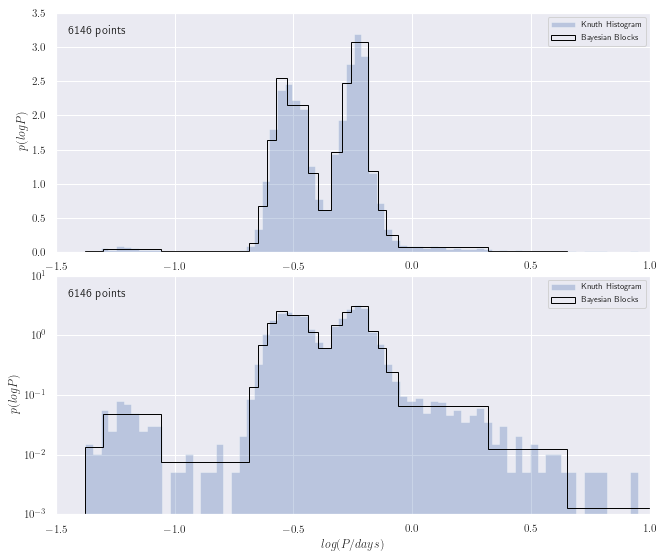

In [14]:
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)

# linear scale
ax = fig.add_subplot(211)
hist(x, bins='knuth', ax=ax, normed=True,  
         histtype='stepfilled', alpha=0.3,
         label='Knuth Histogram')
hist(x, bins='blocks', ax=ax, normed=True,  
         histtype='step', color='black', alpha=0.99,
         label="Bayesian Blocks")
# label the plot
ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
ax.set_ylabel('$p(logP)$')
ax.legend(loc='upper right', prop=dict(size=8))

ax.set_xlim(-1.5, 1.0)
ax.set_ylim(0, 3.5)

# log scale
ax = fig.add_subplot(212)
hist(x, bins='knuth', ax=ax, normed=True, log=True,
         histtype='stepfilled', alpha=0.3,
         label='Knuth Histogram')
hist(x, bins='blocks', ax=ax, normed=True, log=True,
         histtype='step', color='black', alpha=0.99,
         label="Bayesian Blocks")
# label the plot
ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
ax.set_ylabel('$p(logP)$')
ax.legend(loc='upper right', prop=dict(size=8))

ax.set_xlabel('$log(P/days)$')
ax.set_xlim(-1.5, 1.0)
ax.set_ylim(0.001, 10)

plt.show()

